In [1]:
!pip install torch_geometric

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
!pip install openpyxl

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
import pandas as pd
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
import warnings
import os
import shutil
warnings.filterwarnings("ignore")
from interval_model.NNIG import nn_fuzzy_information_granular
from interval_model.NNIG1209 import nn_fuzzy_information_granular1209
from interval_model.FIG import fuzzy_information_granular
from interval_model.lube import lube
from util.parameters import Parameters
from util.util import MSE, mae_loss, mape_loss,rmse_loss
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tqdm import tqdm
from torch_geometric.data import InMemoryDataset
import torch
from DCRNN_model.DCRNN1 import DCRNN


In [4]:
params = Parameters()
epochs = 100
n_country = 42
node_features = params.node_fea
lr = params.lr
weight_decay = params.weight_decay

In [5]:
face_mobility = pd.read_excel("dataset/country_sci.xlsx")
face_mobility.columns = ['No','index_from','index_to', 'weight','from_3','to_3','from_2','to_2']
face_mobility

,No,index_from,index_to,weight,from_3,to_3,from_2,to_2
0,0,0,35,37678,USA,HND,US,HN
1,1,0,42,34992,USA,DOM,US,DO
2,2,0,28,21651,USA,GTM,US,GT
3,3,0,14,12209,USA,CAN,US,CA
4,4,0,2,11901,USA,MEX,US,MX
...,...,...,...,...,...,...,...,...
445,445,44,14,3159,NPL,CAN,NP,CA
446,446,44,0,2931,NPL,USA,NP,US
447,447,44,20,2582,NPL,PHL,NP,PH
448,448,44,30,2448,NPL,HRV,NP,HR


在表格中取国家的名称

In [6]:
country_name = face_mobility['from_3'].unique() 
country_name

array(['USA', 'BRA', 'MEX', 'IND', 'GBR', 'ITA', 'FRA', 'ESP', 'COL',
       'ARG', 'ZAF', 'IDN', 'UKR', 'TUR', 'CAN', 'CHL', 'BEL', 'HUN',
       'ECU', 'BGR', 'PHL', 'BOL', 'CHE', 'JPN', 'BGD', 'TUN', 'MAR',
       'GRC', 'GTM', 'SAU', 'HRV', 'KAZ', 'SRB', 'MDA', 'IRL', 'HND',
       'PRY', 'SVN', 'GEO', 'AZE', 'LTU', 'ARM', 'DOM', 'DZA', 'NPL'],
      dtype=object)

In [7]:
edge_index = torch.tensor([face_mobility['index_from'], face_mobility['index_to']], dtype=torch.long)

In [8]:
edge_weight = torch.tensor([face_mobility['weight']])
edge_attr = torch.tensor(face_mobility['weight'], dtype=torch.float)

In [9]:
country_data_case = pd.read_csv("dataset/第三章输入数据.csv", delimiter=",")
country_data_case.columns

Index(['date', 'USA', 'BRA', 'MEX', 'IND', 'GBR', 'ITA', 'FRA', 'ESP', 'COL',
       'ARG', 'ZAF', 'IDN', 'UKR', 'TUR', 'CAN', 'CHL', 'BEL', 'HUN', 'ECU',
       'BGR', 'PHL', 'BOL', 'CHE', 'JPN', 'BGD', 'TUN', 'MAR', 'GRC', 'GTM',
       'SAU', 'HRV', 'KAZ', 'SRB', 'MDA', 'IRL', 'HND', 'PRY', 'SVN', 'GEO',
       'AZE', 'LTU', 'ARM', 'DOM', 'DZA', 'NPL'],
      dtype='object')

In [10]:
country_data_case = country_data_case[['MEX', 'GBR', 'ITA', 'FRA', 'ESP', 'COL',
       'ARG', 'ZAF', 'IDN', 'UKR', 'TUR', 'CAN', 'CHL', 'BEL', 'HUN', 'ECU',
       'BGR', 'PHL', 'BOL', 'CHE', 'JPN', 'BGD', 'TUN', 'MAR', 'GRC', 'GTM',
       'SAU', 'HRV', 'KAZ', 'SRB', 'MDA', 'IRL', 'HND', 'PRY', 'SVN', 'GEO',
       'AZE', 'LTU', 'ARM', 'DOM', 'DZA', 'NPL']].T
country_data_case

,0,1,2,3,4,5,6,7,8,9,...,831,832,833,834,835,836,837,838,839,840
MEX,163.0,132.0,178.0,202.0,253.0,296.0,346.0,396.0,260.0,403.0,...,5986.000000,6465.166667,6944.333333,7423.500000,7902.666667,8381.833333,8861.00,0.00,3866.25,7732.5
GBR,4938.0,4896.0,4924.0,4071.0,3611.0,5329.0,5460.0,5152.0,4868.0,4324.0,...,0.000000,0.000000,0.000000,0.000000,1330.000000,26785.600000,26785.60,26785.60,26785.60,26785.6
ITA,4782.0,4668.0,4585.0,4805.0,4316.0,3599.0,3039.0,3836.0,4204.0,3951.0,...,83761.000000,87719.481481,91677.962963,95636.444444,93510.222222,91384.000000,68996.00,32051.00,28059.70,24068.4
FRA,4843.0,2100.0,5223.0,40617.3,846.0,2658.0,40617.3,3851.0,3784.0,1566.0,...,42547.333333,85094.666667,42547.333333,0.000000,0.000000,0.000000,0.00,67241.50,53929.40,40617.3
ESP,8195.0,7947.0,7134.0,6969.0,5478.0,5029.0,5267.0,6278.0,5002.0,5051.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,7847.55,15695.1
COL,159.0,96.0,106.0,139.0,79.0,94.0,201.0,274.0,169.0,250.0,...,0.000000,0.000000,0.000000,24649.000000,7452.200000,7452.200000,7452.20,7452.20,7452.20,7452.2
ARG,0.0,79.0,132.0,186.0,0.0,103.0,74.0,87.0,80.0,180.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5647.25,11294.50,11294.50,11294.5
ZAF,27.0,82.0,43.0,80.0,70.0,31.0,63.0,96.0,89.0,69.0,...,706.000000,0.000000,491.000000,0.000000,0.000000,1285.000000,0.00,0.00,1143.00,4744.9
IDN,149.0,113.0,196.0,106.0,181.0,218.0,247.0,218.0,337.0,219.0,...,1681.000000,3361.000000,3822.000000,3584.000000,3331.000000,4329.000000,3540.00,3393.00,5085.00,7311.8
UKR,149.0,103.0,175.0,153.0,83.0,11.0,143.0,206.0,224.0,311.0,...,36.000000,36.000000,34.000000,41.000000,1112.000000,55.000000,57.00,79.00,63.00,6296.8


In [11]:
np.array(country_data_case.iloc[1,:10])

array([4938., 4896., 4924., 4071., 3611., 5329., 5460., 5152., 4868.,
       4324.])

In [12]:
import numpy as np

def min_max_scaling(data, min_val=0, max_val=1):
    min_original = np.min(data)
    max_original = np.max(data)
    denominator = max_original - min_original if max_original != min_original else 1.0
    normalized_data = min_val + (max_val - min_val) * (data - min_original) / denominator
    return normalized_data, min_original, max_original

def inverse_min_max_scaling(normalized_data, min_original, max_original, min_val=0, max_val=1):
    return ((normalized_data - min_val) / (max_val - min_val)) * (max_original - min_original) + min_original

def standard_scaling(data):
    mean_original = np.mean(data)
    std_original = np.std(data)
    standardized_data = (data - mean_original) / std_original
    return standardized_data, mean_original, std_original

def inverse_standard_scaling(standardized_data, mean_original, std_original):  
    standardized_data = standardized_data.T
    destandardized_data = standardized_data * std_original + mean_original  
    return destandardized_data

In [13]:
def slide_window(data, lookback_days, lookforward_days, gap_days):
    x_list,y_list = [],[]
    len_data_column = data.shape[1]
    for i in range(0, len_data_column - lookback_days - lookforward_days + 1, gap_days):
        y = np.array(data[:,i+lookback_days:i + lookback_days + lookforward_days], dtype=np.float64)
        x = np.array(data[:,i:i + lookback_days], dtype=np.float64)
        x = x.reshape(x.shape[0],x.shape[1])
        y = y.reshape(y.shape[0],y.shape[1])
        x_list.append(x)
        y_list.append(y)
    return torch.tensor(x_list),torch.tensor(y_list)

In [14]:
def data_process(country_data_case,fig_day,lookback_pattern,look_forward,classification):
    nnig = nn_fuzzy_information_granular1209(country_data_case)
    FIG = fuzzy_information_granular(country_data_case.T.values, fig_day)
    if classification=='nnig':
        lower_np, med_np, upper_np = nnig.get_FIG_result(country_data_case,fig_day)
    elif classification=='lube':
        med_np, lower_np, upper_np = lube(country_data_case.T.values, fig_day)
    elif classification=='fig':
        lower_np, med_np, upper_np = FIG.get_FIG_result(fig_day)
    med_normalized_data, med_min_original, med_max_original = standard_scaling(med_np)
    lower_normalized_data, lower_min_original, lower_max_original = standard_scaling(lower_np)
    upper_normalized_data, upper_min_original, upper_max_original = standard_scaling(upper_np)
    all_data_normalized_data,_,_= standard_scaling(country_data_case)
    
    med_np_x,med_np_y = slide_window(med_normalized_data, lookback_pattern, look_forward, 1)
    lower_np_x,lower_np_y = slide_window(lower_normalized_data, lookback_pattern, look_forward, 1)
    upper_np_x,upper_np_y = slide_window(upper_normalized_data, lookback_pattern, look_forward, 1)
    
    lower_data_list,med_data_list,upper_data_list = [],[],[]
    for i in range(len(med_np_x)):
        lower_data_list.append(Data(x=lower_np_x[i], y=lower_np_y[i], edge_index=edge_index,edge_attr=edge_attr))
        med_data_list.append(Data(x=med_np_x[i], y=med_np_y[i], edge_index=edge_index,edge_attr=edge_attr))
        upper_data_list.append(Data(x=upper_np_x[i], y=upper_np_y[i], edge_index=edge_index,edge_attr=edge_attr))
    return med_np,lower_np,upper_np,lower_data_list,med_data_list,upper_data_list,lower_min_original, lower_max_original,upper_min_original, upper_max_original, med_min_original, med_max_original,all_data_normalized_data

In [15]:
def split_dataset(lower_data_list):
    sample = len(lower_data_list)
    sample *= 1.0
    lower_train_dataset = lower_data_list[:int(0.7 * sample)]
    lower_val_dataset = lower_data_list[int(0.7 * sample):int(0.85 * sample)]
    lower_test_dataset = lower_data_list[int(0.85 * sample):int(sample)]
    return lower_train_dataset,lower_val_dataset,lower_test_dataset

In [16]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent1 = DCRNN(in_channels=node_features, out_channels = 32, K=1)
        self.linear1 = torch.nn.Linear(32, look_forward)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data, h1):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        h = self.recurrent1(x, edge_index, edge_weight, h1)
        h = F.relu(h)
        h = self.linear1(h)
        h = self.dropout(h)
        return h

In [17]:
def validation(test_dataset):
    model = torch.load('./dataset/output/model.pth')
    prediction ,labels= [],[]
    loss_func = MSE
    rmse = rmse_loss 
    mse = MSE
    mape = mape_loss
    mae = mae_loss
    test_rmse_set,test_mse_set,test_mape_set,test_mae_set,test_losses_set = [],[],[],[],[]
    model.eval()
    for time, snapshot in enumerate(test_dataset):
        h1, c = None, None
        test_cost,test_rmse,test_mape,test_mae = 0,0,0,0
        y_hat = model(snapshot, h1)
        prediction.append(y_hat)
        labels.append(snapshot.y)
        test_rmse += rmse_loss(y_hat, snapshot.y)
        test_mape += mape_loss(y_hat, snapshot.y)
        test_mae += mae_loss(y_hat, snapshot.y)
        test_cost += MSE(y_hat, snapshot.y)
    test_rmse /= time + 1
    test_cost /= time + 1
    test_mape /= time + 1
    test_mae /= time + 1
    # print()
    print("测试集结果：RMSE: {:.4f}, MAE:{:.4f}".format(test_rmse,test_mae))
    test_rmse_set.append(test_rmse.item())
    test_mape_set.append(test_mape.item())
    test_mae_set.append(test_mae.item())
    test_losses_set.append(test_cost.item())
    result = {'rmse': [], 'mape': [], 'mae': []}
    result['rmse'] = test_rmse_set
    result['mape'] = test_mape_set
    result['mae'] = test_mae_set
    return prediction,labels,result


In [18]:
import os
def train_val_test_dataset(train_dataset, val_dataset,test_dataset):
    file_path = './dataset/output/model.pth'  # 文件路径，根据实际情况进行修改   
    if os.path.isfile(file_path):  
        try:  
            os.remove(file_path)  # 删除文件  
            print(f"成功删除文件: {file_path}")  
        except Exception as e:  
            print(f"删除文件时发生错误: {e}")  
    else:  
        print(f"文件不存在: {file_path}")
    model = RecurrentGCN(node_features=lookback_pattern)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, eps=1e-08)
    model = model.double()
    loss_func = MSE
    rmse = rmse_loss 
    mape = mape_loss
    mae = mae_loss
    val_rmse_set,val_mape_set,val_mae_set,val_losses_set = [],[],[],[]
    
    for epoch in range(epochs):
        train_val_predictions = {'train': [], 'val': []}
        train_val_labels = {'train': [], 'val': []}
        model.train()
        train_cost,train_nrmse,train_mape,train_mae = 0,0,0,0
        val_cost,val_rmse,val_mape,val_mae = 0,0,0,0
        for time, snapshot in enumerate(train_dataset):
            h1 = None
            # print(snapshot.y.shape,snapshot.x.shape)
            y_hat = model(snapshot, h1)
            train_val_predictions['train'].append(y_hat)
            train_val_labels['train'].append(snapshot.y)
            train_cost += loss_func(y_hat, snapshot.y)
        train_cost /= time + 1
        train_cost.backward()
        optimizer.step()
        optimizer.zero_grad()
        with torch.no_grad():
            model.eval()
            for time, snapshot in enumerate(val_dataset):
                h1 = None
                y_hat = model(snapshot, h1)
                train_val_predictions['val'].append(y_hat)
                train_val_labels['val'].append(snapshot.y)
                val_cost += loss_func(y_hat, snapshot.y)
                val_rmse += rmse(y_hat, snapshot.y)
                val_mape += mape(y_hat, snapshot.y)
                val_mae += mae(y_hat, snapshot.y)
            val_cost /=  time + 1
            val_rmse /=  time + 1
            val_mape /=  time + 1
            val_mae /=  time + 1
            val_rmse_set.append(val_rmse.item())
            val_mape_set.append(val_mape.item())
            val_mae_set.append(val_mae.item())
            val_losses_set.append(val_cost.item())
            if epoch%20==0:
                print('Epoch: {:02d}, Train cost: {:.5f}, Val cost: {:.5f}'
                      .format(epoch, train_cost,  val_cost))
    torch.save(model,'./dataset/output/model.pth')
    best_epoch = val_losses_set.index(min(val_losses_set))
    best_rmse = float(val_rmse_set[best_epoch])
    best_mape = float(val_mape_set[best_epoch])
    best_mae = float(val_mae_set[best_epoch])
    train_val_result = {'rmse': [], 'mape': [], 'mae': []}
    train_val_result['rmse'] = best_rmse
    train_val_result['mape'] = best_mape
    train_val_result['mae'] = best_mae
    # print('RMSE:',best_rmse)
    # print('MAPE:',best_mape)
    # print('MAE:',best_mae)
    test_prediction,test_labels,test_result = validation(test_dataset)
    return train_val_predictions,train_val_labels,train_val_result,test_prediction,test_labels,test_result

In [19]:
def result_process(data,look_forward):
    result = []
    for i in range(n_country):
        result.append(data[:,i*look_forward])
    return pd.DataFrame(result)

def get_result(look_forward,train_dataset,val_dataset,test_dataset,train_val_prediction,test_prediction):
    get_input ,get_pre= [],[]
    sample = len(train_dataset)+len(val_dataset)+len(test_dataset)
    sample *= 1.0
    for i in range(int(sample)):
        if i < len(train_dataset):
            get_input.append(train_dataset[i].y.numpy().ravel())
            get_pre.append(train_val_prediction['train'][i].detach().numpy().ravel())
        elif len(train_dataset) < i < len(train_dataset)+len(val_dataset):
            get_input.append(val_dataset[i - (len(train_dataset))].y.detach().numpy().ravel())  # 44
            get_pre.append(train_val_prediction['val'][i - (len(train_dataset))].detach().numpy().ravel())  # 44
        else:
            get_input.append(test_dataset[i - (len(train_dataset)+len(val_dataset))].y.detach().numpy().ravel()) 
            get_pre.append(test_prediction[i - (len(train_dataset)+len(val_dataset))].detach().numpy().ravel())
    get_gpn = np.array(get_pre)
    get_gin = np.array(get_input)
    if look_forward != 1:
        get_gpn = result_process(get_gpn,look_forward)
        get_gin = result_process(get_gin,look_forward)
    return np.array(get_gpn),np.array(get_gin)

In [20]:
def data_list_process(data,look_forward):
    if look_forward>1:
        data_np = data.numpy()
        data_np = data_np.reshape(data.shape[1],data.shape[0],data.shape[2])
    return data_np[:,:,0]


In [21]:
def huizong_jieguo(nnig_picp,nnig_pinad,nnig_pinaw,nnig_pinrw):
    nnig_max_values = [np.array(nnig_picp).max(), np.array(nnig_pinad).max(), np.array(nnig_pinaw).max(), np.array(nnig_pinrw).max()]
    nnig_min_values = [np.array(nnig_picp).min(), np.array(nnig_pinad).min(), np.array(nnig_pinaw).min(), np.array(nnig_pinrw).min()]
    nnig_mean_values = [np.array(nnig_picp).mean(), np.array(nnig_pinad).mean(), np.array(nnig_pinaw).mean(), np.array(nnig_pinrw).mean()] 
    
    nnig_results = pd.DataFrame({  
    'Max': nnig_max_values,  
    'Min': nnig_min_values,  
    'Mean': nnig_mean_values  
    },index = ['PICP','PINAD','PINAW(%)','PINRW(%)'])  
    return nnig_results

---------------------------------------

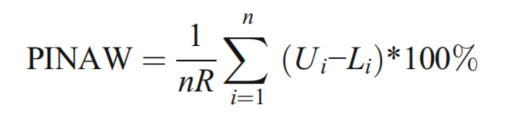

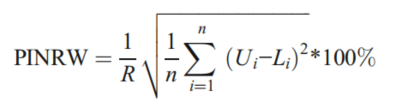

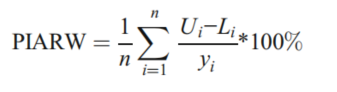

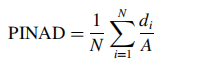

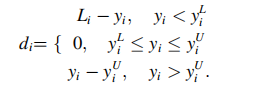

In [35]:
fig_days = [11,9,7,5]
lookback_patterns = [7,5,3]
look_forwards = [3,1]
for fig_day in fig_days:
    for lookback_pattern in lookback_patterns:
        for look_forward in look_forwards:
            print(fig_day,lookback_pattern,look_forward)
# fig_days = [11,9]
# lookback_patterns = [7]
# look_forwards = [3]

11 7 3
11 7 1
11 5 3
11 5 1
11 3 3
11 3 1
9 7 3
9 7 1
9 5 3
9 5 1
9 3 3
9 3 1
7 7 3
7 7 1
7 5 3
7 5 1
7 3 3
7 3 1
5 7 3
5 7 1
5 5 3
5 5 1
5 3 3
5 3 1


In [ ]:
from util.pi_rm import PICP,PINAD,PINAW,PIARW,PINRW
all_result = []
for fig_day in fig_days:
    for lookback_pattern in lookback_patterns:
        for look_forward in look_forwards:
            print('---------------------------------------------------------------')
            print('fig_day         :',fig_day)
            print('lookback_pattern:',lookback_pattern)
            print('look_forward    :',look_forward)
            
            #处理数据
            nnig_med_np,nnig_lower_np,nnig_upper_np,nnig_lower_data_list,nnig_med_data_list,nnig_upper_data_list,nnig_lower_min_original, nnig_lower_max_original,nnig_upper_min_original, nnig_upper_max_original, nnig_med_min_original, nnig_med_max_original,all_data_normalized_data = data_process(country_data_case,fig_day,lookback_pattern,look_forward,'nnig')
            fig_med_np,fig_lower_np,fig_upper_np,fig_lower_data_list,fig_med_data_list,fig_upper_data_list,fig_lower_min_original, fig_lower_max_original,fig_upper_min_original, fig_upper_max_original, fig_med_min_original, fig_med_max_original,all_data_normalized_data = data_process(country_data_case,fig_day,lookback_pattern,look_forward,'fig')
            lube_med_np,lube_lower_np,lube_upper_np,lube_lower_data_list,lube_med_data_list,lube_upper_data_list,lube_lower_min_original, lube_lower_max_original,lube_upper_min_original, lube_upper_max_original, lube_med_min_original, lube_med_max_original,all_data_normalized_data = data_process(country_data_case,fig_day,lookback_pattern,look_forward,'lube')
            
            #划分数据
            nnig_lower_train_dataset,nnig_lower_val_dataset,nnig_lower_test_dataset = split_dataset(nnig_lower_data_list)
            nnig_med_train_dataset,nnig_med_val_dataset,nnig_med_test_dataset = split_dataset(nnig_med_data_list)
            nnig_upper_train_dataset,nnig_upper_val_dataset,nnig_upper_test_dataset = split_dataset(nnig_upper_data_list)
            
            fig_lower_train_dataset,fig_lower_val_dataset,fig_lower_test_dataset = split_dataset(fig_lower_data_list)
            fig_med_train_dataset,fig_med_val_dataset,fig_med_test_dataset = split_dataset(fig_med_data_list)
            fig_upper_train_dataset,fig_upper_val_dataset,fig_upper_test_dataset = split_dataset(fig_upper_data_list)
            
            lube_lower_train_dataset,lube_lower_val_dataset,lube_lower_test_dataset = split_dataset(lube_lower_data_list)
            lube_med_train_dataset,lube_med_val_dataset,lube_med_test_dataset = split_dataset(lube_med_data_list)
            lube_upper_train_dataset,lube_upper_val_dataset,lube_upper_test_dataset = split_dataset(lube_upper_data_list)
            
            #训练模型
            print('------------FIG-----------')
            fig_lower_train_val_predictions,fig_lower_train_val_labels,fig_lower_train_val_result,fig_lower_test_prediction,fig_lower_test_labels,fig_lower_test_result = train_val_test_dataset(fig_lower_train_dataset, fig_lower_val_dataset,fig_lower_test_dataset)
            fig_med_train_val_predictions,fig_med_train_val_labels,fig_med_train_val_result,fig_med_test_prediction,fig_med_test_labels,fig_med_test_result = train_val_test_dataset(fig_med_train_dataset, fig_med_val_dataset,fig_med_test_dataset)
            fig_upper_train_val_predictions,fig_upper_train_val_labels,fig_upper_train_val_result,fig_upper_test_prediction,fig_upper_test_labels,fig_upper_test_result = train_val_test_dataset(fig_upper_train_dataset, fig_upper_val_dataset,fig_upper_test_dataset)
            print('------------LUBE-----------')
            lube_lower_train_val_predictions,lube_lower_train_val_labels,lube_lower_train_val_result,lube_lower_test_prediction,lube_lower_test_labels,lube_lower_test_result = train_val_test_dataset(lube_lower_train_dataset, lube_lower_val_dataset,lube_lower_test_dataset)
            lube_med_train_val_predictions,lube_med_train_val_labels,lube_med_train_val_result,lube_med_test_prediction,lube_med_test_labels,lube_med_test_result = train_val_test_dataset(lube_med_train_dataset, lube_med_val_dataset,lube_med_test_dataset)
            lube_upper_train_val_predictions,lube_upper_train_val_labels,lube_upper_train_val_result,lube_upper_test_prediction,lube_upper_test_labels,lube_upper_test_result = train_val_test_dataset(lube_upper_train_dataset, lube_upper_val_dataset,lube_upper_test_dataset)
            print('------------NNIG-----------')
            nnig_lower_train_val_predictions,nnig_lower_train_val_labels,nnig_lower_train_val_result,nnig_lower_test_prediction,nnig_lower_test_labels,nnig_lower_test_result = train_val_test_dataset(nnig_lower_train_dataset, nnig_lower_val_dataset,nnig_lower_test_dataset)
            nnig_med_train_val_predictions,nnig_med_train_val_labels,nnig_med_train_val_result,nnig_med_test_prediction,nnig_med_test_labels,nnig_med_test_result = train_val_test_dataset(nnig_med_train_dataset, nnig_med_val_dataset,nnig_med_test_dataset)
            nnig_upper_train_val_predictions,nnig_upper_train_val_labels,nnig_upper_train_val_result,nnig_upper_test_prediction,nnig_upper_test_labels,nnig_upper_test_result = train_val_test_dataset(nnig_upper_train_dataset, nnig_upper_val_dataset,nnig_upper_test_dataset)
            
            #取结果
            nnig_upper_gpn,nnig_upper_gin = get_result(look_forward,nnig_upper_train_dataset,nnig_upper_val_dataset,nnig_upper_test_dataset,nnig_upper_train_val_predictions,nnig_upper_test_prediction)
            nnig_med_gpn,nnig_med_gin = get_result(look_forward,nnig_med_train_dataset,nnig_med_val_dataset,nnig_med_test_dataset,nnig_med_train_val_predictions,nnig_med_test_prediction)
            nnig_lower_gpn,nnig_lower_gin = get_result(look_forward,nnig_lower_train_dataset,nnig_lower_val_dataset, nnig_lower_test_dataset,nnig_lower_train_val_predictions,nnig_lower_test_prediction)

            fig_upper_gpn,fig_upper_gin = get_result(look_forward,fig_upper_train_dataset,fig_upper_val_dataset,fig_upper_test_dataset,fig_upper_train_val_predictions,fig_upper_test_prediction)
            fig_med_gpn,fig_med_gin = get_result(look_forward,fig_med_train_dataset,fig_med_val_dataset,fig_med_test_dataset,fig_med_train_val_predictions,fig_med_test_prediction)
            fig_lower_gpn,fig_lower_gin = get_result(look_forward,fig_lower_train_dataset,fig_lower_val_dataset, fig_lower_test_dataset,fig_lower_train_val_predictions,fig_lower_test_prediction)

            lube_upper_gpn,lube_upper_gin = get_result(look_forward,lube_upper_train_dataset,lube_upper_val_dataset,lube_upper_test_dataset,lube_upper_train_val_predictions,lube_upper_test_prediction)
            lube_med_gpn,lube_med_gin = get_result(look_forward,lube_med_train_dataset,lube_med_val_dataset,lube_med_test_dataset,lube_med_train_val_predictions,lube_med_test_prediction)
            lube_lower_gpn,lube_lower_gin = get_result(look_forward,lube_lower_train_dataset,lube_lower_val_dataset, lube_lower_test_dataset,lube_lower_train_val_predictions,lube_lower_test_prediction)

            
            #反归一化
            nnig_lower_gpn_inverse_normalized = inverse_standard_scaling(nnig_lower_gpn, nnig_lower_min_original, nnig_lower_max_original)
            nnig_med_gpn_inverse_normalized = inverse_standard_scaling(nnig_med_gpn, nnig_med_min_original, nnig_med_max_original)
            nnig_upper_gpn_inverse_normalized = inverse_standard_scaling(nnig_upper_gpn, nnig_upper_min_original, nnig_upper_max_original)
            nnig_lower_gin_inverse_normalized = inverse_standard_scaling(nnig_lower_gin,nnig_lower_min_original,nnig_lower_max_original)
            nnig_med_gin_inverse_normalized = inverse_standard_scaling(nnig_med_gin,nnig_med_min_original,nnig_med_max_original)
            nnig_upper_gin_inverse_normalized = inverse_standard_scaling(nnig_upper_gin,nnig_upper_min_original,nnig_upper_max_original)

            fig_lower_gpn_inverse_normalized = inverse_standard_scaling(fig_lower_gpn, fig_lower_min_original, fig_lower_max_original)
            fig_lower_gin_inverse_normalized = inverse_standard_scaling(fig_lower_gin, fig_lower_min_original, fig_lower_max_original)
            fig_med_gpn_inverse_normalized = inverse_standard_scaling(fig_med_gpn, fig_med_min_original, fig_med_max_original)
            fig_med_gin_inverse_normalized = inverse_standard_scaling(fig_med_gin, fig_med_min_original, fig_med_max_original)
            fig_upper_gpn_inverse_normalized = inverse_standard_scaling(fig_upper_gpn, fig_upper_min_original, fig_upper_max_original)
            fig_upper_gin_inverse_normalized = inverse_standard_scaling(fig_upper_gin, fig_upper_min_original, fig_upper_max_original)

            lube_lower_gpn_inverse_normalized = inverse_standard_scaling(lube_lower_gpn, lube_lower_min_original, lube_lower_max_original)
            lube_lower_gin_inverse_normalized = inverse_standard_scaling(lube_lower_gin, lube_lower_min_original, lube_lower_max_original)
            lube_med_gpn_inverse_normalized = inverse_standard_scaling(lube_med_gpn, lube_med_min_original, lube_med_max_original)
            lube_med_gin_inverse_normalized = inverse_standard_scaling(lube_med_gin, lube_med_min_original, lube_med_max_original)
            lube_upper_gpn_inverse_normalized = inverse_standard_scaling(lube_upper_gpn, lube_upper_min_original, lube_upper_max_original)
            lube_upper_gin_inverse_normalized = inverse_standard_scaling(lube_upper_gin, lube_upper_min_original, lube_upper_max_original)
            
            

            max_set,min_set,a_set,a_set_normalized = [],[],[],[]

            for i in range(n_country):
                a_set_normalized.append(all_data_normalized_data.iloc[i,:].max()-all_data_normalized_data.iloc[i,:].min())
                # a_set.append(country_data_case.iloc[i,:].max()-country_data_case.iloc[i,:].min())
                a_set.append(nnig_upper_gin_inverse_normalized[i,:].max()-nnig_lower_gin_inverse_normalized[i,:].min())
            a_set = np.array(a_set)
            a_set_normalized = np.array(a_set_normalized)
            
            
            nnig_picp,nnig_pinad,nnig_pinaw,nnig_pinrw= [], [], [],[]
            fig_picp,fig_pinad,fig_pinaw,fig_pinrw = [], [], [],[]
            lube_picp,lube_pinad,lube_pinaw,lube_pinrw = [], [], [],[]

            for i in range(n_country):
                nnig_picp.append(PICP(nnig_med_gin_inverse_normalized[i,:], nnig_upper_gpn_inverse_normalized[i,:], nnig_lower_gpn_inverse_normalized[i,:]))
                nnig_pinad.append(PINAD(nnig_upper_gpn_inverse_normalized[i,:], nnig_lower_gpn_inverse_normalized[i,:], nnig_med_gin_inverse_normalized[i,:],a_set[i]))
                nnig_pinaw.append(PINAW(nnig_upper_gpn_inverse_normalized[i,:], nnig_lower_gpn_inverse_normalized[i,:], a_set[i]))
                nnig_pinrw.append(PINRW(nnig_upper_gpn_inverse_normalized[i,:], nnig_lower_gpn_inverse_normalized[i,:], a_set[i]))

                fig_picp.append(PICP(fig_med_gin_inverse_normalized[i,:], fig_upper_gpn_inverse_normalized[i,:], fig_lower_gpn_inverse_normalized[i,:]))
                fig_pinad.append(PINAD(fig_upper_gpn_inverse_normalized[i,:], fig_lower_gpn_inverse_normalized[i,:], fig_med_gin_inverse_normalized[i,:],a_set[i]))
                fig_pinaw.append(PINAW(fig_upper_gpn_inverse_normalized[i,:], fig_lower_gpn_inverse_normalized[i,:],a_set[i]))
                fig_pinrw.append(PINRW(fig_upper_gpn_inverse_normalized[i,:], fig_lower_gpn_inverse_normalized[i,:], a_set[i]))

                lube_picp.append(PICP(lube_med_gin_inverse_normalized[i,:], lube_upper_gpn_inverse_normalized[i,:], lube_lower_gpn_inverse_normalized[i,:]))
                lube_pinad.append(PINAD(lube_upper_gpn_inverse_normalized[i,:], lube_lower_gpn_inverse_normalized[i,:], lube_med_gin_inverse_normalized[i,:],a_set[i]))
                lube_pinaw.append(PINAW(lube_upper_gpn_inverse_normalized[i,:], lube_lower_gpn_inverse_normalized[i,:],a_set[i]))
                lube_pinrw.append(PINRW(lube_upper_gpn_inverse_normalized[i,:], lube_lower_gpn_inverse_normalized[i,:], a_set[i]))

            nnig_results = huizong_jieguo(nnig_picp,nnig_pinad,nnig_pinaw,nnig_pinrw)
            fig_results = huizong_jieguo(fig_picp,fig_pinad,fig_pinaw,fig_pinrw)
            lube_results = huizong_jieguo(lube_picp,lube_pinad,lube_pinaw,lube_pinrw)
            
            temp_result = {'fig_day': [], 'lookback_pattern': [], 'look_forward': [], 'nnig_results': [], 'fig_results': [], 'lube_results': []}
            temp_result['fig_day']=fig_day
            temp_result['lookback_pattern']=lookback_pattern
            temp_result['look_forward']=look_forward
            temp_result['nnig_results']=nnig_results
            temp_result['fig_results']=fig_results
            temp_result['lube_results']=lube_results
            
            print('nnig_results')
            print(nnig_results)
            print('fig_results')
            print(fig_results)
            print('lube_results')
            print(lube_results)
            
            all_result.append(temp_result)
print('已结束循环')

---------------------------------------------------------------
fig_day         : 11
lookback_pattern: 7
look_forward    : 3
------------FIG-----------
成功删除文件: ./dataset/output/model.pth
Epoch: 00, Train cost: 0.42499, Val cost: 4.20316
Epoch: 20, Train cost: 0.36847, Val cost: 3.83461
Epoch: 40, Train cost: 0.33719, Val cost: 3.53612
Epoch: 60, Train cost: 0.31723, Val cost: 3.39284
Epoch: 80, Train cost: 0.31551, Val cost: 3.27586


In [ ]:
for i in range(len(all_result)):
    print(all_result[i]['fig_day'],all_result[i]['lookback_pattern'],all_result[i]['look_forward'])
    print(all_result[i]['nnig_results'])

In [ ]:
nnig_results_df = pd.DataFrame()
fig_results_df = pd.DataFrame()
lube_results_df = pd.DataFrame()
for i in range(len(all_result)):
    nnig_results_df = pd.concat([all_result[i]['nnig_results'],nnig_results_df])
    fig_results_df = pd.concat([all_result[i]['fig_results'],fig_results_df])
    lube_results_df = pd.concat([all_result[i]['lube_results'],lube_results_df])
result_df = pd.concat([nnig_results_df,fig_results_df,lube_results_df],axis = 1)
result_df.to_csv('dataset/output/区间预测结果1210(3).csv')

In [ ]:
result_df